### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.callbacks import *

np.random.seed(42)
torch.cuda.set_device(0)

from annoy import AnnoyIndex

import glob

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

## Creating dataframes and partitioning the data

In [3]:
#creating df of image names & dataset label (train, val, test)
img_partitions = pd.read_csv('./Eval/list_eval_partition.txt', delim_whitespace=True, header=1)

#creating df of attribute names and type label
attributes = pd.read_csv(
    './Anno/list_attr_cloth.txt', 
    sep='\s{2,}', 
    header=0, 
    skiprows=[0], 
    engine='python')

attributes_imgs = pd.read_csv(
    './Anno/list_attr_img.txt', 
    delim_whitespace=True, 
    header=0,
    skiprows=[0],
    names=(['image_name'] + attributes['attribute_name'].tolist()))
attributes_imgs.replace([-1,0,1],[False,False,True], inplace=True)

#creating df of image names, attribute tags, and dataset label
attributes_df = attributes_imgs.merge(img_partitions, how ='left', on='image_name')

In [4]:
# 1 = Texture, 2 = Fabric, 3 = Shape, 4 = Parts
list_attr_names = ['image_name']+attributes[(attributes['attribute_type']==4)]['attribute_name'].tolist()
training_df = attributes_df[attributes_df['evaluation_status'].isin(['train','val'])][list_attr_names].copy()
training_df.reset_index(drop=True, inplace=True)

In [ ]:
#removing images from DF with no label
training_df['max'] = [training_df.iloc[x][1:].max() for x in training_df.index.tolist()]
training_df = training_df[training_df['max'].isin([True])].copy()
training_df.drop('max', axis=1, inplace=True)

In [ ]:
test_df = cleaned_df[cleaned_df['evaluation_status'].isin(['test'])][['image_name','category_name']].copy()
training_df['category_name'].value_counts()
test_df['category_name'].value_counts().plot()

In [6]:
def count_attr_imgs(attr_df):
    col_counts = {}

    for col in attr_df.columns[1:]:
        col_counts[col] = attr_df[col].value_counts().to_frame().loc[True][0]
    
    col_df = pd.DataFrame.from_dict(col_counts, orient='index', columns=['Count'])
    
    return col_df

#.sort_values(by='Count')

## Data distribution

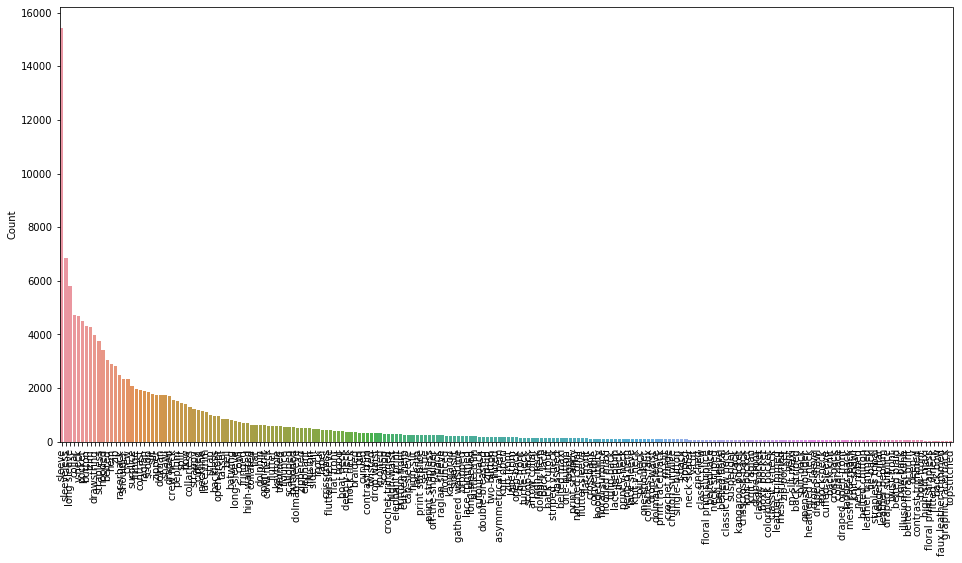

In [7]:
plt.figure(figsize=(16,8))
sns.barplot(x=count_attr_imgs(training_df).sort_values(by='Count',ascending=False).index,y=count_attr_imgs(training_df).sort_values(by='Count',ascending=False)['Count'])
plt.xticks(rotation=90);

## top 25 part attribute classes

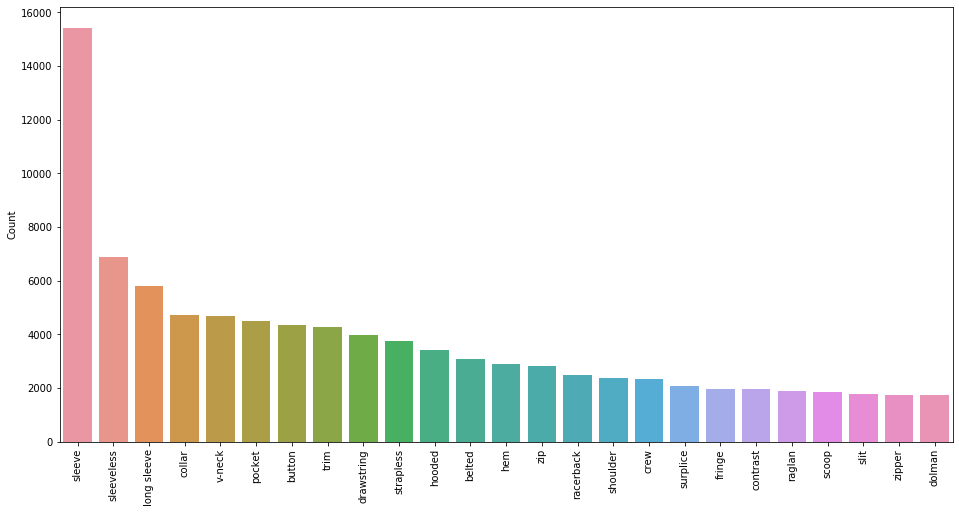

In [8]:
plt.figure(figsize=(16,8))
sns.barplot(x=count_attr_imgs(training_df).sort_values(by='Count',ascending=False)[:25].index,y=count_attr_imgs(training_df).sort_values(by='Count',ascending=False)[:25]['Count'])
plt.xticks(rotation=90);

In [9]:
from fastai import *
from fastai.vision import *
np.random.seed(42)
torch.cuda.set_device(0)

In [ ]:
label_column_names = training_df.columns.tolist()[1:]

img_base_path = Path("./Img/")
data = ImageDataBunch.from_df(img_base_path, training_df, ds_tfms=get_transforms(), size=224, label_col=label_column_names)
data.normalize(imagenet_stats)

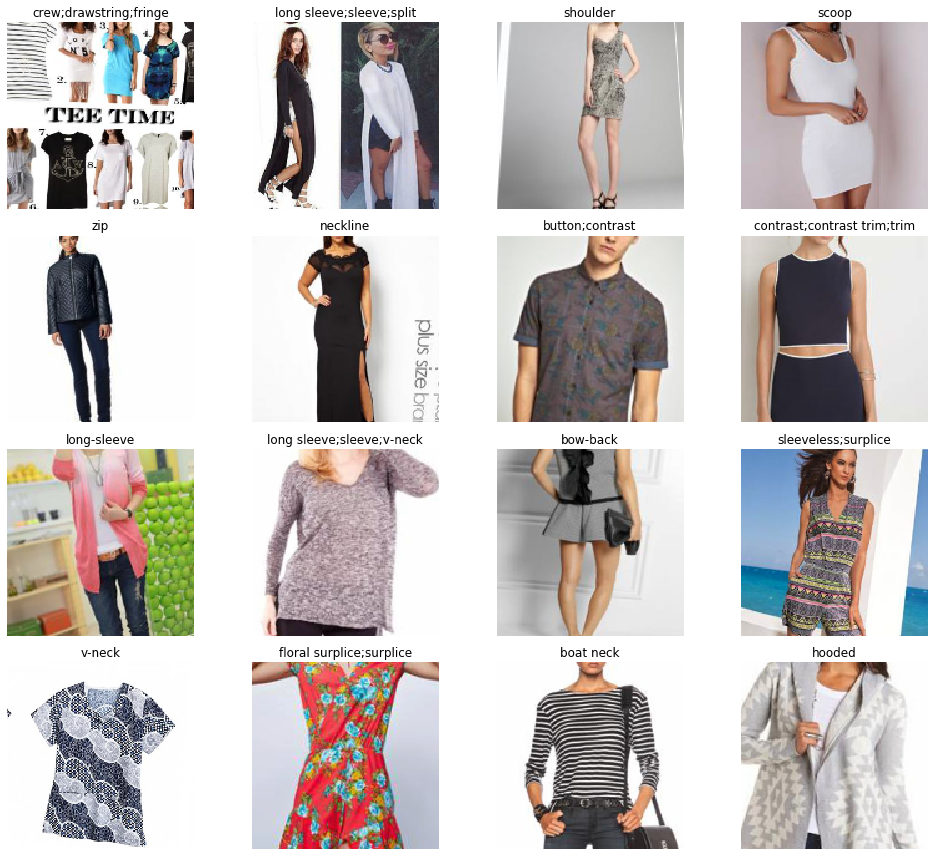

In [11]:
data.show_batch(rows=4, figsize=(14,12))

In [12]:
print(data.classes)
len(data.classes),data.c


['arrow collar', 'asymmetrical hem', 'back bow', 'back cutout', 'back knit', 'back lace', 'back striped', 'backless', 'batwing', 'beaded collar', 'bell', 'bell-sleeve', 'belted', 'belted chiffon', 'belted floral', 'belted floral print', 'belted lace', 'belted maxi', 'belted plaid', 'boat neck', 'bow', 'bow-back', 'bow-front', 'boxy pocket', 'braided', 'button', 'button-front', 'buttoned', 'cap-sleeve', 'chiffon surplice', 'cinched', 'classic crew', 'classic crew neck', 'classic pocket', 'classic v-neck', 'collar', 'collar lace', 'collared', 'collarless', 'collarless faux', 'colorblock pocket', 'contrast', 'contrast trim', 'contrast-trimmed', 'convertible', 'cowl', 'cowl neck', 'crew', 'crew neck', 'crisscross', 'crisscross-back', 'crochet fringe', 'crochet-trimmed', 'cross-back', 'crossback', 'cuffed', 'cuffed-sleeve', 'curved', 'curved hem', 'cutout-back', 'deep v-neck', 'deep-v', 'dolman', 'dolman sleeve', 'dolman-sleeve', 'dolphin', 'dolphin hem', 'double-breasted', 'drape-front', '

(216, 216)

In [13]:
acc_03 = partial(accuracy_thresh, thresh=0.3)
f_score = partial(fbeta, thresh=0.2)

Metrics utilised for multi label, accuracy threshold and f_score

In [14]:
learn = cnn_learner(data, models.resnet50, metrics=[acc_03, f_score], callback_fns=ShowGraph, bs = )

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.032000,0.030479,0.987980,0.211520,06:44
1,0.029816,0.028446,0.987149,0.282720,06:36
2,0.028882,0.027601,0.987422,0.303187,06:35
3,0.027857,0.027127,0.986689,0.321400,06:35
4,0.027621,0.027014,0.986744,0.324896,06:35


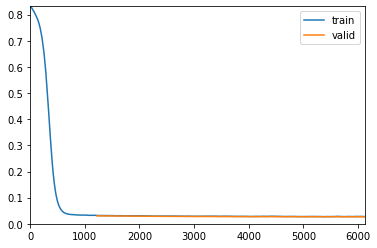

In [15]:
learn.fit_one_cycle(5)

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


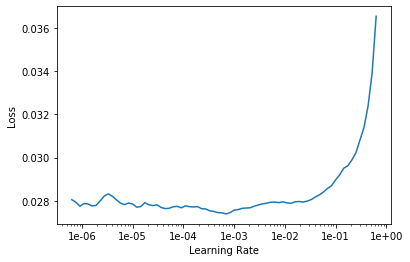

In [17]:
learn.recorder.plot()

In [18]:
learn.unfreeze()

slice(1, 2, None)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.030377,0.032692,0.986109,0.266457,08:28
1,0.029003,0.027742,0.986716,0.319129,08:22
2,0.027274,0.026108,0.988262,0.359589,08:20
3,0.025801,0.025306,0.987337,0.381243,08:20


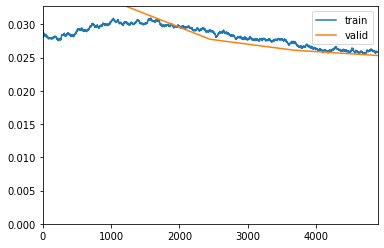

In [19]:
learn.fit_one_cycle(4, slice(1e-4,1e-2))

In [20]:
learn.save('parts-resnet50-size150-fr5-unfr4', return_path=True)
learn.export('parts-resnet50-size150-fr5-unfr4.pkl')

[('belted', 0.2596837282180786), ('double-breasted', 0.1971598118543625), ('hooded', 0.19647322595119476), ('button', 0.19269317388534546), ('collar', 0.08249390870332718)]


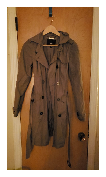

In [29]:
predict_img_path = "data/zens2.jpg" 
category,classIndex,losses = learn.predict(open_image(predict_img_path))
predictions = sorted(zip(data.classes, map(float, losses)), key=lambda p: p[1], reverse=True)
print (predictions[:5])
show_image(open_image(predict_img_path))

# "/data/Michael/data/predict/2.png"